# Parte 2 del detector Fruit-Quality

Para esta segunda parte de nuestro detector probaremos con nuevas imágenes de manzana, así como otros tipos de frutas, para poder usarlo en cualquier tipo de fruta y nos daría un resultado óptimo.

Comenzaremos poniendo nuevas imágenes de manzanas en las que se vea más claro el defecto, para comprobar como de fiable es nuestro programa.

### Manzana muy defectuosa

La primera imagen será la de una manzana que se encuentra con un gran agujero en un lado. Esta fruta se puede reconocer fácilmente que no se encuentra en buenas condiciones para su consumo.

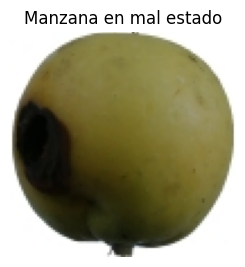

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
images_path = './images/'

# Mostramos la imagen de la manzana
img_mala = cv2.imread(images_path + "ManzanaM_2.jpg")
img_mala_rgb = cv2.cvtColor(img_mala, cv2.COLOR_BGR2RGB)


plt.subplot(1,2,2)
plt.title("Manzana en mal estado")
plt.imshow(img_mala_rgb)
plt.axis("off")
plt.show()

Pondremos todos los pasos para comprobar como lo detecta y ver donde puede estar el fallo.

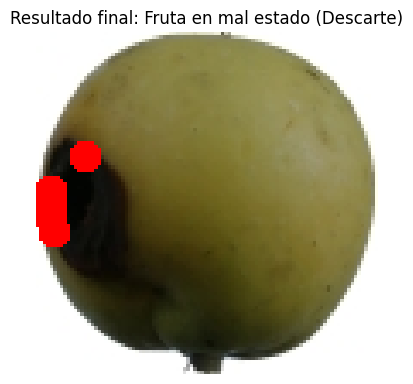

In [64]:
gray = cv2.cvtColor(img_mala, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

sobelx = cv2.Sobel(gray_blur, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_blur, cv2.CV_64F, 0, 1, ksize=3)
gradiente = cv2.magnitude(sobelx, sobely)
gradiente = cv2.convertScaleAbs(gradiente)

gray_norm = cv2.normalize(gray_blur, None, 0, 255, cv2.NORM_MINMAX)
grad_norm = cv2.normalize(gradiente, None, 0, 255, cv2.NORM_MINMAX)
defect_score = cv2.addWeighted(255 - gray_norm, 0.7, grad_norm, 0.3, 0)

_, defect_mask = cv2.threshold(defect_score, 180, 255, cv2.THRESH_BINARY)
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))

# Inicializa las variables para el análisis
total_pixels = gray.shape[0] * gray.shape[1]
defect_pixels_total = cv2.countNonZero(defect_mask)
porcentaje_defecto = (defect_pixels_total / total_pixels) * 100

UMBRAL_AREA_GRAVE = 15

estado = "Fruta en buen estado"
hay_defecto_grave = False

contornos, _ = cv2.findContours(defect_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

hay_defecto_grave = any(cv2.contourArea(contorno) > UMBRAL_AREA_GRAVE for contorno in contornos)

resultado = img_mala_rgb.copy()

if hay_defecto_grave:
    estado = "Fruta en mal estado (Descarte)"
    cv2.drawContours(resultado, contornos, -1, (255, 0, 0), thickness=3)
else:
    estado = "Fruta en buen estado (Venta o Consumición)"

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.title(f"Resultado final: {estado}")
plt.imshow(resultado)
plt.axis("off")

plt.show()

Una vez hemos ejecutado todo el código, podemos ver que la solución de nuestro programa es correcta, pero no es de la forma más óptima que se podría hacer, ya que vemos que detecta ciertos bordes pero no la zona por completo, ya que al estar usando la primera derivada, nos detecta los bordes, pero al ser una imagen con cierta iluminación por diferentes zonas, y tener la zona defectuosa en un color más oscuro, nuestro programa no lo detecta bien, por lo que haremos ciertos cambios.

## Arreglo

Para poder arreglar nuestro programa, cambiaremos ciertos algoritmos que usamos para detectar de una forma más precisa la zona defectuosa. En primer lugar aplicaremos un histograma para poder diferenciar las zonas con una baja intensidad y clasificarlos como defectuoso.

En primer lugar cargamos la imagen para ver al inicio como es, así como realizar un preprocesamiento de la imagen, donde aplicamos un suavizado por mediana, para eliminar todo tipo de ruido que pueda haber, manteniendo los bordes intactos para poder analizarlos bien más adelante

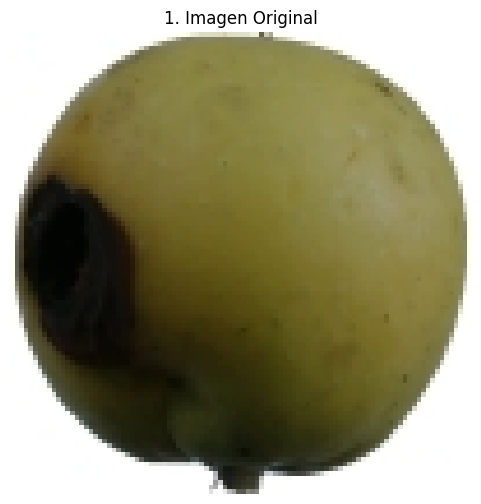

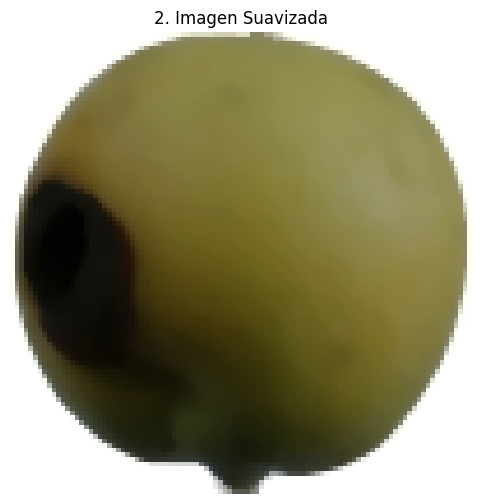

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para mostrar imágenes
def show(img, title="", cmap=None):
    plt.figure(figsize=(6,6))
    if cmap is None:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Cargar imagen
path = './images/ManzanaM_2.jpg'
img = cv2.imread(path)
original = img.copy()

if img is None:
    print("Error: No se pudo cargar la imagen. Revisa la ruta.")
else:
    show(original, "Imagen Original")


# 2. Suavizado para eliminar ruido
blurred = cv2.medianBlur(img, 5)

Deberemos de aplicar un histograma para detectar las zonas más oscuras de la imagen. En lugar de considerar oscuro todo lo que esté por debajo de un valor fijo, usaremos el algoritmo de Otsu. Este analiza el histograma de luz de la foto y nos calcula matemáticamente el punto exacto que nos separa la piel clara de las manchas más oscuras.

Esto nos generará una máscara en blanco y negro, donde lo blanco son los posibles defectos oscuros.

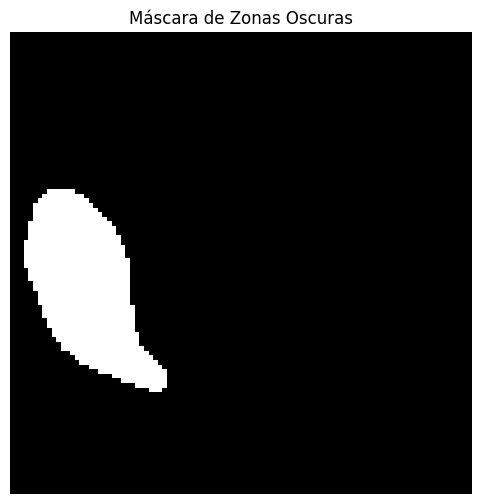

In [71]:
# 3. Detección de zonas oscuras (Histograma)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([gray], [0], None, [256], [0,256])

# Buscamos el pico de oscuridad en los primeros 100 valores y sumamos un margen
shadow_thresh = np.argmax(hist[:100]) + 5
_, shadow_mask = cv2.threshold(gray, shadow_thresh, 255, cv2.THRESH_BINARY)

# Limpiamos ruido en la máscara y la invertimos para que lo BLANCO sea lo OSCURO
shadow_mask = cv2.medianBlur(shadow_mask, 9)
shadow_mask = cv2.bitwise_not(shadow_mask)

show(shadow_mask, "Máscara de Zonas Oscuras", cmap='gray')

En la imagen podemos ver que detecta de forma bastante buena el área de la imagen que se encuentra defectuosa.

Una vez obtenido el histograma, buscaremos si puede llegar a haber algún falso positivo, ya que el paso anterior nos puede detectar zonas que no son defectuosas, como el tallo de la manzana o una sombra algo pequeña.

Para comprobar que todo ha salido bien, el código buscará el defecto de dos formas a la vez: 

- Por el color, que busca los píxeles que tengan un color algo raro.

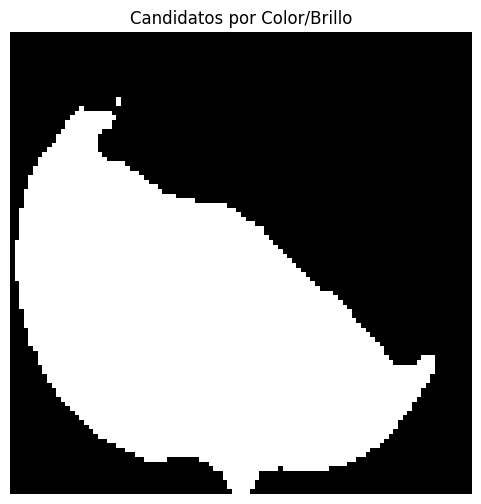

In [73]:
# 4. Detección por rango de color (HSV)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

# Rango: Cualquier matiz (0-180), saturación media-alta, pero brillo BAJO (0-120)
lower_defect = np.array([0, 30, 0])
upper_defect = np.array([180, 255, 120])

color_mask = cv2.inRange(hsv, lower_defect, upper_defect)

show(color_mask, "Candidatos por Color/Brillo", cmap='gray')

- Por bordes, usando el algoritmo de Canny, que busca los cambios bruscos en la superficie.

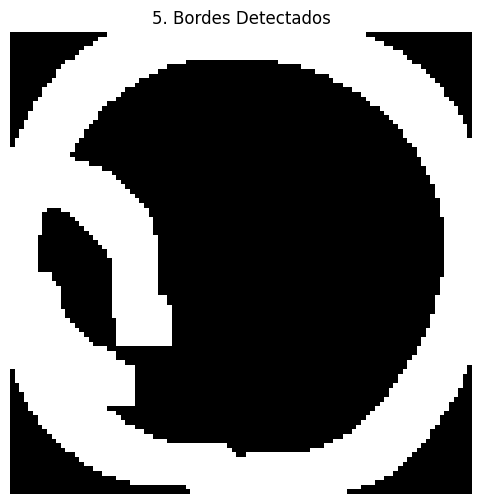

In [68]:
# 5. Detección de bordes
edges = cv2.Canny(gray, 40, 120)
# Engrosamos los bordes para conectarlos mejor
edges = cv2.dilate(edges, np.ones((5,5), np.uint8), iterations=2)

show(edges, "5. Bordes Detectados", cmap='gray')

Finalmente, nuestro código tomará todas las pistas que hemos creado previamente para dibujar el contorno final.

Se marcará el área de defecto si cumple ambas condiciones:
- Tiene un borde extraño o tiene un color extraño.
- Está dentro de la zona oscura detectada por el algoritmo de Otsu.

Esto nos detectará si hay una sombra pero no tiene bordes de textura, el código la ignorará, y si tien bordes pero no es oscura, el código la ignorará.

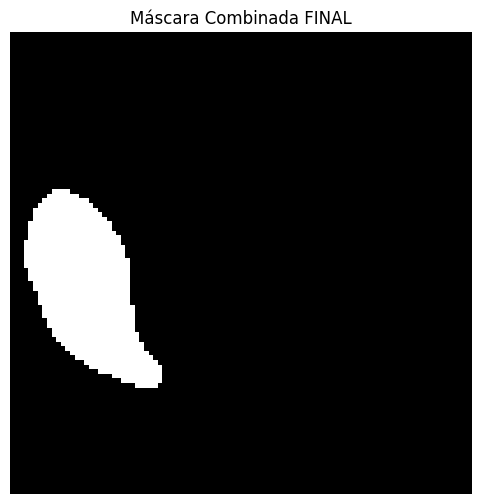

In [ ]:
# Solo aceptamos bordes que caigan dentro de la zona oscura
defect_edges = cv2.bitwise_and(edges, edges, mask=shadow_mask)

# Solo aceptamos defectos de color que caigan dentro de la zona oscura
defect_color = cv2.bitwise_and(color_mask, color_mask, mask=shadow_mask)

# 7. Combinación
combined = cv2.bitwise_or(defect_edges, defect_color)

# Fallback de seguridad (si la combinación borra todo, volvemos al color)
if np.sum(combined) < 20:
    print("Aviso: Detección combinada muy baja, usando solo color.")
    combined = defect_color

# Limpieza final de la máscara combinada
combined = cv2.medianBlur(combined, 7)
show(combined, "Máscara Combinada FINAL", cmap='gray')

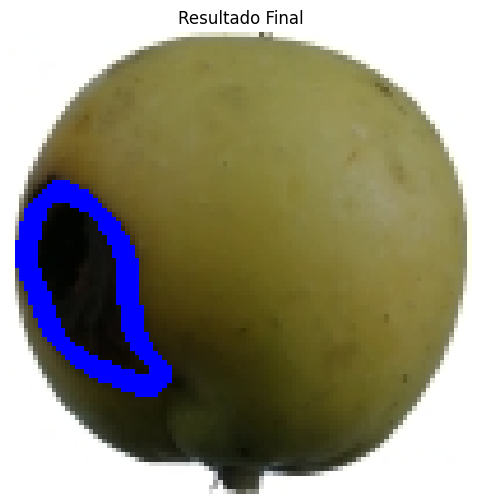

In [74]:
# Mostramos resultado final con contornos
resultado = original.copy()
contornos, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujamos en azul (BGR: 255, 0, 0) con grosor 3
cv2.drawContours(resultado, contornos, -1, (255, 0, 0), thickness=3)

show(resultado, "Resultado Final")